## Задание 1. Исследование связей между двумя исследуемыми признаками.

**Условие задачи**: По 20 туристическим фирмам были установлены затраты на рекламную компанию и количетсов туристов, воспользовавшихся после ее проведения услугами каждой фирмы.
Определить коэффициент корреляции между исследумыми признаками.


Импортируем необходимые библиотеки.

In [61]:
import pandas as pd
import numpy as np
import math

Создадим DataFrame с используемыми данными.

In [62]:
costs = [5, 5, 7, 8, 9, 10, 11, 12, 13, 14,
         15, 15, 16, 17, 18, 18, 19, 20, 20, 21]
tourists = [720, 750, 800, 820, 800, 880, 950, 820, 900, 950,
            920, 980, 980, 970, 980, 1010, 1100, 1100, 1115, 1100]

df = pd.DataFrame({'costs': costs, 'tourists': tourists})
print(df)

    costs  tourists
0       5       720
1       5       750
2       7       800
3       8       820
4       9       800
5      10       880
6      11       950
7      12       820
8      13       900
9      14       950
10     15       920
11     15       980
12     16       980
13     17       970
14     18       980
15     18      1010
16     19      1100
17     20      1100
18     20      1115
19     21      1100


Рассчитаем коэффициент корреляции.

In [63]:
def get_corr(df: pd.DataFrame) -> float:
    return df.corr().iloc[0, 1]

In [64]:
coef_corr = get_corr(df)
print(f'Коэффициент корреляции: {coef_corr:.4f}')

Коэффициент корреляции: 0.9523


Оценим тесноту связи.

In [65]:
corr_coefs = [0.25, 0.44, 0.64, 0.8, 0.9, 1]
closeness = ['очень слабая', 'слабая', 'умеренная',
             'сильная', 'весьма сильная', 'очень сильная']

def get_closeness(corr: float) -> str:
    corr = abs(corr)
    if corr < 0 or corr > 1:
        return 'error: corr out of range [-1; 1]'
    for i in range(len(corr_coefs)):
        if corr <= corr_coefs[i]:
            return closeness[i]

In [66]:
print(f'Теснота связи при коэфф. корр. {coef_corr:.2f}: {get_closeness(coef_corr)}')

Теснота связи при коэфф. корр. 0.95: очень сильная


Рассчитаем t-статистику Стьюдента.

In [67]:
def students_t_test(df: pd.DataFrame) -> float:
    r = get_corr(df)
    n = df.shape[0]
    return r * math.sqrt(n-2) / math.sqrt(1 - r ** 2)

In [68]:
st_test = students_t_test(df)
print(f't-статистика Стьюдента: {st_test:.4f}')

t-статистика Стьюдента: 13.2404


Сравним полученное значение с критическим.

In [69]:
st_test_crit = 1.734

print(f'Критическое значения критерия Стьюдента в данном случае (табличное значение): {st_test_crit:.4f}')
print(f'Расчетное значение критерия Стьюдента в нашей задаче: {st_test:.4f}')

if st_test >= st_test_crit:
    print('t(расч) >= t(табл) => существует зависимость')
else:
    print('t(расч) < t(табл) => величины независимы')

Критическое значения критерия Стьюдента в данном случае (табличное значение): 1.7340
Расчетное значение критерия Стьюдента в нашей задаче: 13.2404
t(расч) >= t(табл) => существует зависимость


## Задание 2. Построение регрессионной модели.

Импортируем библиотеки.

In [70]:
import matplotlib.pyplot as plt
from typing import Tuple, Callable

Вспомогательные функции для удобного вывода и построения графиков.

In [71]:
def reg_coef_to_str(reg_coefs: Tuple[float, float]) -> str:
    a = reg_coefs[0]
    b = reg_coefs[1]
    return f'y = {a:.2f} * x + {b:.2f}'


def show_plot(df: pd.DataFrame, reg_coef: Tuple[float, float], xlabel='', ylabel='', title='', with_text_info=False, with_line=False):
    a, b = reg_coef[0], reg_coef[1]

    if with_text_info:
        print(f'Коэффициент корреляции: {get_corr(df):.4f}')
        print(reg_coef_to_str((a, b,)))
    
    if with_line:
        line = [a * i + b for i in df.iloc[:, 0]]
        plt.plot(df.iloc[:, 0], line, 'r')

    plt.scatter(df.iloc[:, 0], df.iloc[:, 1])

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.show()

### Способ 1. Ручками.

In [72]:
def hands_regression(df: pd.DataFrame) -> Tuple[float, float]:
    x = df.iloc[:, 0]
    y = df.iloc[:, 1]
    n = len(x)
    a = (n * sum(x * y) - sum(x) * sum(y)) / \
        (n * (sum([i ** 2 for i in x])) - sum(x) ** 2)
    b = 1 / n * sum(y) - a / n * sum(x)
    return a, b

Коэффициент корреляции: 0.9523
y = 22.51 * x + 625.03


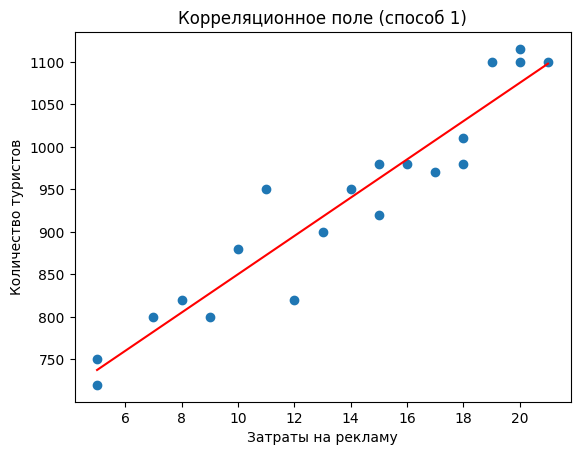

In [73]:
show_plot(df, hands_regression(df), xlabel='Затраты на рекламу', ylabel='Количество туристов',
          title='Корреляционное поле (способ 1)', with_text_info=True, with_line=True)


### Способ 2. Используя библиотеку scikit-learn.

In [74]:
from sklearn import linear_model

# return coefs and R^2
def skl_regression(df):
    x_name, y_name = df.columns
    x_data, y_data = df[[x_name]].values, df[y_name].values
    
    reg = linear_model.LinearRegression()
    reg.fit(x_data, y_data)
    
    return (reg.coef_[0], reg.intercept_, reg.score(x_data, y_data),)

Коэффициент детерминации: 0.9069
Коэффициент корреляции: 0.9523
y = 22.51 * x + 625.03


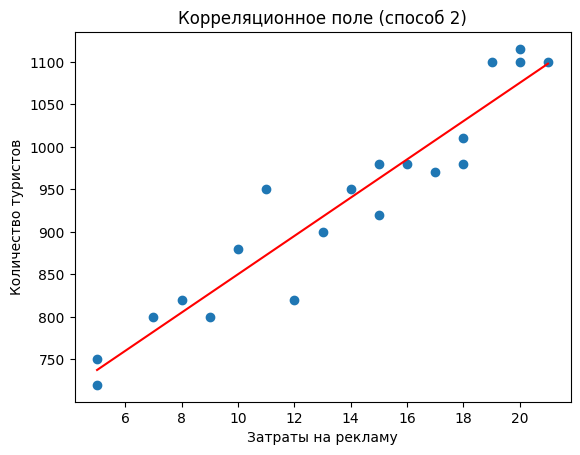

In [75]:
a, b, r = skl_regression(df)
print(f'Коэффициент детерминации: {r:.4f}')

show_plot(df, (a,b,), xlabel='Затраты на рекламу', ylabel='Количество туристов',
          title='Корреляционное поле (способ 2)', with_text_info=True, with_line=True)

### Способ 3. Используя библиотеку numpy.

Коэффициент корреляции: 0.9523
y = 22.51 * x + 625.03


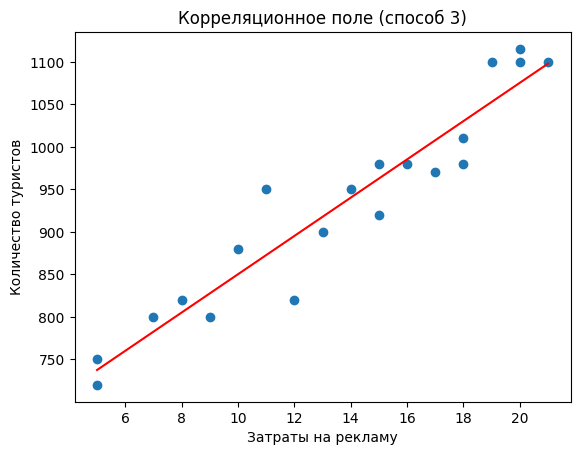

In [76]:
def np_regression(df):
    x_name, y_name = df.columns
    x_data, y_data = df[x_name].values, df[y_name].values
    
    fit = np.polyfit(x_data, y_data, 1)
    return (fit[0], fit[1],)

show_plot(df, np_regression(df), xlabel='Затраты на рекламу', ylabel='Количество туристов',
          title='Корреляционное поле (способ 3)', with_text_info=True, with_line=True)

Как видим, результаты применения трех разных способов одинаковы.

## Задание 3. Выбор наиболее точной модели.

**Условие задачи.** Исследуется зависимость дозы облучения от толщины слоя защитного материала. Имеются результаты 10 экспериментов.
Имеются основания предполагать, что зависимость дозы (функция) от толщины слоя материала (аругмент) может выражаться одним из следующих уравнений:

* **Y = A0 + A1 * X** (линейная модель)
* **Y = A0 * X ^ A1** (степенная модель)
* **Y = A0 + A1 / X** (гиперболическая модель)

Выберите наиболее точную модель и определите ее коэффициенты.

In [77]:
thickness = [15, 8, 14, 12, 10, 7, 20, 5, 24, 18]
dose = [22, 30, 23, 24, 26, 30, 10, 33, 8, 14]

df = pd.DataFrame({'thickness': thickness, 'dose': dose})
df.sort_values(by=['thickness'], inplace=True)
print(df)

   thickness  dose
7          5    33
5          7    30
1          8    30
4         10    26
3         12    24
2         14    23
0         15    22
9         18    14
6         20    10
8         24     8


Коэффициент детерминации: 0.9685
Коэффициент корреляции: -0.9841
y = -1.40 * x + 40.59


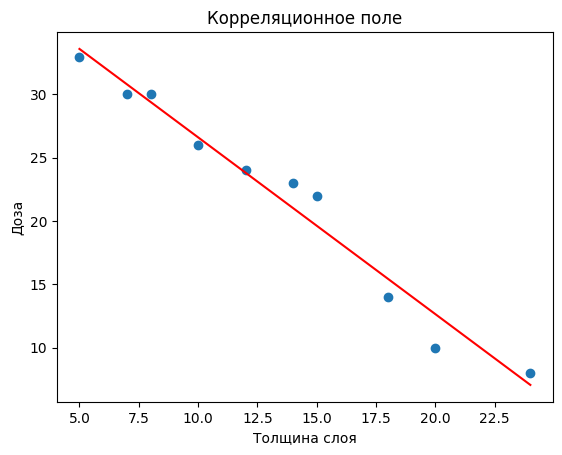

In [78]:
a, b, r = skl_regression(df)
print(f'Коэффициент детерминации: {r:.4f}')

show_plot(df, (a,b,), xlabel='Толщина слоя', ylabel='Доза',
          title='Корреляционное поле', with_text_info=True, with_line=True)

In [79]:
x_name, y_name = df.columns
x_data, y_data = df[x_name].values, df[y_name].values

x_ln_data, y_ln_data = np.log(x_data), np.log(y_data)

a, b, r = skl_regression(pd.DataFrame({'x': x_ln_data, 'y': y_ln_data}))
a, b = math.exp(b), a

print(f'Коэффициент детерминации: {r:.4f}')

Коэффициент детерминации: 0.7972


y = 177.2008 * x ^ -0.8774


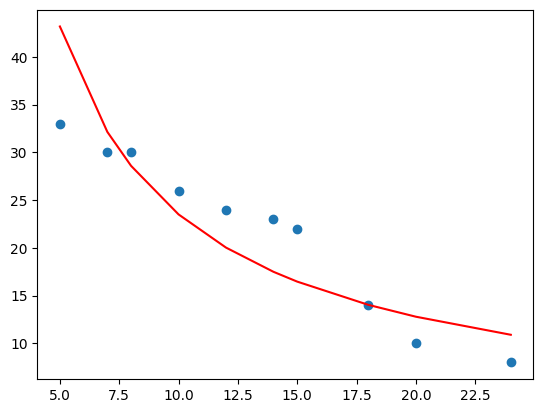

In [80]:
print(f'y = {a:.4f} * x ^ {b:.4f}')

line = [a * (i ** b) for i in df.iloc[:, 0]]
plt.plot(df.iloc[:, 0], line, 'r')
plt.scatter(df.iloc[:, 0], df.iloc[:, 1])

plt.show()

In [81]:
x_name, y_name = df.columns
x_data, y_data = df[x_name].values, df[y_name].values
x_data = 1/x_data

a, b, r = skl_regression(pd.DataFrame({'x': x_data, 'y': y_data}))
a, b = b, a
print(f'Коэффициент детерминации: {r:.4f}')

Коэффициент детерминации: 0.7534


y = 7.8175 + 151.4402 / x


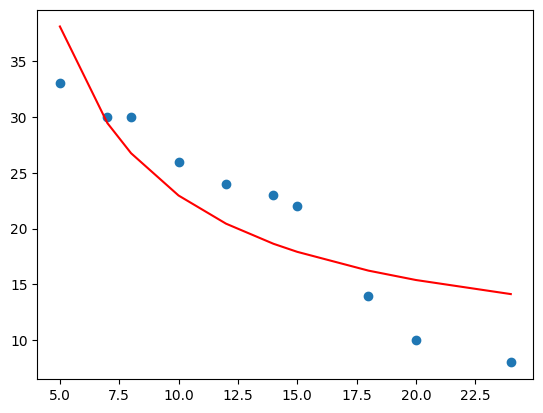

In [82]:
print(f'y = {a:.4f} + {b:.4f} / x')

line = [a + b / i for i in df.iloc[:, 0]]
plt.plot(df.iloc[:, 0], line, 'r')
plt.scatter(df.iloc[:, 0], df.iloc[:, 1])

plt.show()

In [83]:
# TODO: сделать один график со всеми кривыми разным цветом с легендой

## Задание 4А.

Имеются данные по двум экономическим показателям X и Y. Необходимо:
* Вычислить коэффициент корреляции
* Построить корреляционное поле
* Построить регрессионную модель

In [84]:
cost = [997, 987, 1002, 1012, 1011, 1017, 978, 997, 1010, 989]
demand = [120, 140, 115, 100, 100, 90, 150, 130, 95, 155]

df = pd.DataFrame({'cost': cost, 'demand': demand})
df.sort_values(by=['cost'], inplace=True)
print(df)

   cost  demand
6   978     150
1   987     140
9   989     155
0   997     120
7   997     130
2  1002     115
8  1010      95
4  1011     100
3  1012     100
5  1017      90


Коэффициент детерминации: 0.9125
Коэффициент корреляции: -0.9552
y = -1.77 * x + 1888.47


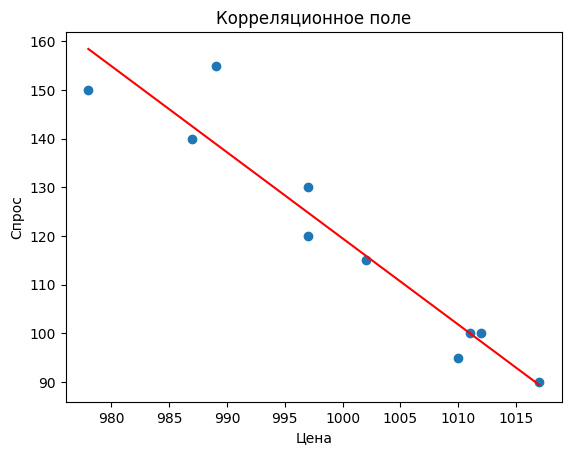

In [85]:
a, b, r = skl_regression(df)
print(f'Коэффициент детерминации: {r:.4f}')

show_plot(df, (a,b,), xlabel='Цена', ylabel='Спрос',
          title='Корреляционное поле', with_text_info=True, with_line=True)

## Задание 4Б.

Установить, зависит ли количество посетителей музея и посетителей парка от числа ясных дней за определенный период. Для этого:
* Вычислить коэффициенты корреляции
* Построить корреляционное поле
* Построить регрессионную модель

In [86]:
clear_days = [8, 14, 20, 25, 20, 15]
museum_visitors = [495, 503, 380, 305, 348, 465]
park_visitors = [132, 348, 643, 865, 743, 541]

df = pd.DataFrame({'clear_days': clear_days,
                  'museum_visitors': museum_visitors,
                  'park_visitors': park_visitors})
df.sort_values(by=['clear_days'], inplace=True)
print(df)

   clear_days  museum_visitors  park_visitors
0           8              495            132
1          14              503            348
5          15              465            541
2          20              380            643
4          20              348            743
3          25              305            865


Коэффициент корреляции: 0.9746
Коэффициент детерминации R2: 0.9498
y = 44.11 * x + -204.60


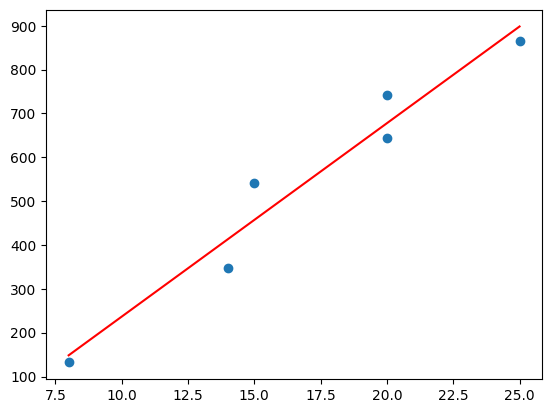

Коэффициент корреляции: -0.9219
Коэффициент детерминации R2: 0.8498
y = -12.90 * x + 635.26


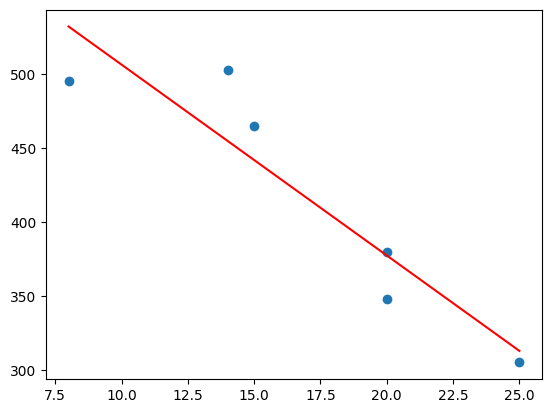

In [100]:
def show_plot_2(df: pd.DataFrame,
                reg_func: Callable[[pd.DataFrame], Tuple[float, float, float]],
                line_calc_func: Callable[[float, float, float], float],
                x_name: str, y_name: str,
                xlabel='', ylabel='', title=''):

    a, b, r = reg_func(df, x_name, y_name)

    # TODO: вынести вывод текста в отдельную функцию, либо выводить руками, надо подумать
    # print(text_func(df, a, b, r))
    print(f'Коэффициент корреляции: {get_corr_2(df, x_name, y_name):.4f}')
    print(f'Коэффициент детерминации R2: {r:.4f}')
    print(reg_coef_to_str((a, b,)))

    line = [line_calc_func(a, b, i) for i in df[x_name]]
    plt.plot(df[x_name], line, 'r')

    plt.scatter(df[x_name], df[y_name])

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.show()

def skl_regression_2(df: pd.DataFrame, x_name: str, y_name: str):
    x_data, y_data = df[[x_name]].values, df[y_name].values
    
    reg = linear_model.LinearRegression()
    reg.fit(x_data, y_data)
    
    return (reg.coef_[0], reg.intercept_, reg.score(x_data, y_data),)

def get_corr_2(df: pd.DataFrame, x_name: str, y_name: str) -> float:
    return df.corr()[x_name][y_name]

show_plot_2(df, skl_regression_2, lambda a, b, i: a * i + b, 'clear_days', 'park_visitors')
show_plot_2(df, skl_regression_2, lambda a, b, i: a * i + b, 'clear_days', 'museum_visitors')